Deep Learning Neural Networks project - CIFAR-10 Image recognition project Ido Degani

# Question 1, part A 
Your task is to explore performance of several neural network architectures. Choose
combinations of fully connected, convolutional, dropout, max pooling and batch
normalization layers. Compare rates of training and inference (time per sample) and
accuracy on train, validation, and test sets. Present your results in informative, simple to
understand and visually appealing manner (e.g. summary table or graphs). Explain your
conclusions (briefly). 

## Choose neural network architectures

#### Data setup & Import

In [3]:
# Import necessary libraries
import imageio
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import random
import numpy as np
import pandas as pd
import math
from PIL import Image 
import seaborn as sns
import time
import sys

# Suppress OpenMP related warnings
os.environ["KMP_WARNINGS"] = "0"

# Import libraries for data preprocessing and evaluation
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 

# Import libraries for data splitting and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

# Initialize PyTorch and set device to use GPU if available
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### import the data:

In [4]:

# Download and load CIFAR-10 train and test datasets
training_cifar_data = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
testing_cifar_data = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### splitting the data to train & test:

In [5]:
# Extract data and labels from CIFAR-10 train and test datasets
x_train = training_cifar_data.data
y_train = training_cifar_data.targets
x_test = testing_cifar_data.data
y_test = testing_cifar_data.targets


#### reshaping the data:

In [6]:
# Reshape CIFAR-10 train and test data from (n_samples, height, width, n_channels) to (n_samples, n_channels, height, width)
X_train = x_train.reshape(-1, 3, 32, 32)
X_test = x_test.reshape(-1, 3, 32, 32)


#### changing the data to tensor:

In [7]:
# Convert the CIFAR-10 training and test data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.uint8)  # Convert the training data to PyTorch tensor and specify the data type as 8-bit unsigned integer
X_test_t = torch.tensor(X_test, dtype=torch.uint8)    # Convert the test data to PyTorch tensor and specify the data type as 8-bit unsigned integer

# Convert the CIFAR-10 training and test labels to PyTorch tensors
y_train_t = torch.tensor(y_train, dtype=torch.uint8)  # Convert the training labels to PyTorch tensor and specify the data type as 8-bit unsigned integer
y_test_t = torch.tensor(y_test, dtype=torch.uint8)    # Convert the test labels to PyTorch tensor and specify the data type as 8-bit unsigned integer


#### Creating validation dataset:

In [8]:
# Split the CIFAR-10 training data and labels into training and validation sets using scikit-learn's train_test_split function
X_train_t, X_validation_t, y_train_t, y_validation_t = train_test_split(X_train_t, y_train_t, test_size=0.05, 
                                                                        shuffle=True, random_state=23)
"""
The train_test_split function randomly splits the CIFAR-10 training data and labels into training and validation sets.
The test_size parameter specifies the size of the validation set as a fraction of the training data.
The shuffle parameter specifies whether to shuffle the data before splitting it.
The random_state parameter ensures that the randomization is consistent across runs.
"""


'\nThe train_test_split function randomly splits the CIFAR-10 training data and labels into training and validation sets.\nThe test_size parameter specifies the size of the validation set as a fraction of the training data.\nThe shuffle parameter specifies whether to shuffle the data before splitting it.\nThe random_state parameter ensures that the randomization is consistent across runs.\n'

#### normalizing the data:

In [9]:
# Normalize the CIFAR-10 training, validation and test data by dividing each pixel value by 255
X_data_normalized = X_train_t.to(dtype=torch.float32) / 255              # Convert the data type to float32 and divide by 255
X_validation_normalized = X_validation_t.to(dtype=torch.float32) / 255  # Convert the data type to float32 and divide by 255
X_test_normalized = X_test_t.to(dtype=torch.float32) / 255                # Convert the data type to float32 and divide by 255
"""
Normalization is an important preprocessing step in deep learning to ensure that the data is on the same scale and the model can learn from the data more effectively. 
Here, we normalize the data by dividing each pixel value by 255 so that the values range from 0 to 1. 
"""


'\nNormalization is an important preprocessing step in deep learning to ensure that the data is on the same scale and the model can learn from the data more effectively. \nHere, we normalize the data by dividing each pixel value by 255 so that the values range from 0 to 1. \n'

#### Define the first architecture

In [10]:
class NeuralNetwork1(nn.Module):
    """Neural network model with customizable input, hidden, and output layers.

    Args:
    input_layer (list of ints): dimensions of the input layer.
    layers (list of ints): dimensions of the hidden layers.
    output_layer (list of ints): dimensions of the output layer.
    drop_out (bool): whether to use dropout regularization.
    batch_norm (bool): whether to use batch normalization.

    Returns:
    torch.Tensor: output logits from the neural network.
    """

    def __init__(self, input_layer=[3*32*32], layers=[512, 256], output_layer=[10], drop_out=False, batch_norm=False):
        super(NeuralNetwork1, self).__init__()

        # Flatten the input tensor.
        self.flatten = torch.nn.Flatten()
        self.input_layer = input_layer[0]
        
        # Combine the input, hidden, and output layers.
        layers = input_layer + layers + output_layer
        
        layers_list = []
        
        # Iterate through each layer.
        for i in range(1, len(layers)):
            # Add a linear layer.
            layers_list.append(torch.nn.Linear(layers[i-1], layers[i]))
            
            # Add a ReLU activation function for all layers except the output layer.
            if i < len(layers)-1:
                layers_list.append(torch.nn.ReLU())
                
                # Add dropout regularization if specified.
                if drop_out:
                    layers_list.append(torch.nn.Dropout(drop_out))
                    
                # Add batch normalization if specified.
                if batch_norm:
                    layers_list.append(torch.nn.BatchNorm1d(layers[i]))

        # Add a log-softmax activation function for the output layer.
        layers_list.append(torch.nn.LogSoftmax())
        
        # Combine all layers into a sequential module.
        self.layers_stack = torch.nn.Sequential(*layers_list)
        self.layers = layers_list 
        
    def forward(self, x):
        """Computes the forward pass through the neural network.

        Args:
        x (torch.Tensor): input tensor.

        Returns:
        torch.Tensor: output logits from the neural network.
        """
        # Flatten the input tensor.
        x = x.view(-1, self.input_layer)
        
        # Compute the forward pass.
        logits = self.layers_stack(x)
        
        return logits


#### Define the seconed architecture

In [11]:
class NeuralNetwork2(torch.nn.Module):
    """Convolutional neural network with customizable convolutional and fully connected layers.

    Args:
    C_in (int): number of input channels.
    H_in (int): height of input images.
    W_in (int): width of input images.
    layers (list of ints): dimensions of the fully connected layers.
    output_layer (list of ints): dimensions of the output layer.
    drop_out (bool): whether to use dropout regularization.
    batch_norm (bool): whether to use batch normalization.

    Returns:
    torch.Tensor: output logits from the convolutional neural network.
    """

    def __init__(self, C_in=3, H_in=32, W_in=32, layers=[512, 256], output_layer=[10], drop_out=False, batch_norm=False):
        super(NeuralNetwork2, self).__init__()

        self.C_in = C_in
        self.H_in = H_in
        self.W_in = W_in
        
        # Define the convolutional layers.
        conv1 = torch.nn.Conv2d(in_channels=C_in, out_channels=20, kernel_size=4, padding=1)
        relu1 = torch.nn.ReLU()
        
        # Compute the output shape of the first convolutional layer.
        out_channels_conv1, H_out_conv1, W_out_conv1 = convolutional_output_tensor_shape(conv_layer=conv1, H_in=H_in, W_in=W_in, verbose=False)
        
        conv2 = torch.nn.Conv2d(in_channels=conv1.out_channels, out_channels=4, kernel_size=5, padding=2)
        relu2 = torch.nn.ReLU()

        # Compute the output shape of the second convolutional layer.
        out_channels_conv2, H_out_conv2, W_out_conv2 = convolutional_output_tensor_shape(conv_layer=conv2, H_in=H_out_conv1, W_in=W_out_conv1, verbose=False)

        conv_layers_list = [conv1, relu1, conv2, relu2]
        self.conv_layers = conv_layers_list
        self.conv_layers_stack = torch.nn.Sequential(*conv_layers_list) #this will enable getting params that can be trained
        
        input_layer_for_fully_connected_layer_1 = [out_channels_conv2*H_out_conv2*W_out_conv2]
        layers = input_layer_for_fully_connected_layer_1 + layers + output_layer # default: 3072x512x256x10        
        
        layers_list = []
        
        # Iterate through each layer.
        for i in range(1, len(layers)):
            # Add a linear layer.
            layers_list.append(torch.nn.Linear(layers[i-1], layers[i]))
            
            # Add a ReLU activation function for all layers except the output layer.
            if i < len(layers)-1:
                layers_list.append(torch.nn.ReLU())
                
                # Add dropout regularization if specified.
                if drop_out:
                    layers_list.append(torch.nn.Dropout(drop_out))
                    
                # Add batch normalization if specified.
                if batch_norm:
                    layers_list.append(torch.nn.BatchNorm1d(layers[i]))

        # Add a log-softmax activation function for the output layer.
        layers_list.append(torch.nn.LogSoftmax())
        
        # Combine all layers into a sequential module.
        self.layers_stack = torch.nn.Sequential(*layers_list)
        self.layers = layers_list 
        
    def forward(self, x):
        """Computes the forward pass through the convolutional neural network.

        Args:
        x (torch.Tensor): input tensor.

        Returns:
        torch.Tensor: output logits from the convolutional neural network.
        """
        # Reshape the input tensor to a 4D tensor.
        x = x.view(-1, self.C_in, self.H_in, self.W_in)
        batch_size = x.shape[0] 

        # Compute the forward pass through the convolutional layers.
        x = self.conv_layers_stack(x)
        
        # Flatten the output tensor.
        x = x.view(batch_size, -1)
        
        # Compute the forward pass through the fully connected layers.
        logits = self.layers_stack(x)
        
        return logits


In [12]:
def convolutional_output_tensor_shape(conv_layer, H_in=32, W_in=32, verbose=True):
    """Computes the output shape after applying a convolutional layer to an input tensor.

    Args:
    conv_layer (torch.nn.Conv2d): convolutional layer.
    H_in (int): height of input tensor.
    W_in (int): width of input tensor.
    verbose (bool): whether to print the output shape.

    Returns:
    tuple: number of output channels, output height, output width.
    """
    out_channels = conv_layer.out_channels
    in_channels = conv_layer.in_channels
    kernel_size = conv_layer.kernel_size
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation
    
    H_out = math.floor(((H_in + 2*padding[0] - dilation[0]*(kernel_size[0] - 1) - 1)/stride[0]) + 1)
    W_out = math.floor(((W_in + 2*padding[1] - dilation[1]*(kernel_size[1] - 1) - 1)/stride[1]) + 1)
    
    if verbose:
        print(f"Input Channels = {in_channels} | Output Channels = {out_channels}")
        print(f"Output shape: num_images X {out_channels} X {H_out} X {W_out}")
    
    return out_channels, H_out, W_out


def convolutional_maxpooling_output_shape(conv_layer, maxpoolayer, H_in=32, W_in=32, verbose=True):
    """Computes the output shape after applying a convolutional layer and max pooling layer to an input tensor.

    Args:
    conv_layer (torch.nn.Conv2d): convolutional layer.
    maxpoolayer (torch.nn.MaxPool2d): max pooling layer.
    H_in (int): height of input tensor.
    W_in (int): width of input tensor.
    verbose (bool): whether to print the output shape.

    Returns:
    tuple: number of output channels, output height, output width.
    """
    out_channels = conv_layer.out_channels
    in_channels = conv_layer.in_channels
    kernel_size = conv_layer.kernel_size
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation
    H_out_conv = math.floor(((H_in + 2*padding[0] - dilation[0]*(kernel_size[0] - 1) - 1)/stride[0]) + 1)
    W_out_conv = math.floor(((W_in + 2*padding[1] - dilation[1]*(kernel_size[1] - 1) - 1)/stride[1]) + 1)
    
    kernel_size_pool = maxpoolayer.kernel_size
    stride_pool = maxpoolayer.stride
    padding_pool = maxpoolayer.padding
    dilation_pool = maxpoolayer.dilation
    H_out_pool = math.floor(((H_out_conv + 2*padding_pool - dilation_pool*(kernel_size_pool - 1) - 1)/stride_pool) + 1)
    W_out_pool = math.floor(((W_out_conv + 2*padding_pool - dilation_pool*(kernel_size_pool - 1) - 1)/stride_pool) + 1)
    
    if verbose:
        print(f"Input Channels = {in_channels} | Output Channels = {out_channels}")
        print(f"Output shape: num_images X {out_channels} X {H_out_pool} X {W_out_pool}")
        
    return out_channels, H_out_pool,


In [13]:
# Define input image shape
num_images = 1
C_in = 3
H_in = 32
W_in = 32

# Print the input shape
print(f"Input shape: {num_images} X {C_in} X {H_in} X {W_in}")

# Define convolutional layer
out_channels = 50
kernel_size = (5, 5)
stride = (7, 5)
padding = (4, 4)
dilation = (1, 1)
conn1 = torch.nn.Conv2d(in_channels=C_in, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
"""
This defines a convolutional layer with the following parameters:
- in_channels: number of input channels (C_in)
- out_channels: number of output channels (out_channels)
- kernel_size: size of the convolutional kernel (5x5)
- stride: size of the stride (7x5)
- padding: size of the padding (4x4)
- dilation: size of the dilation (1x1)
"""

# Define max pooling layer
maxpoolayer = torch.nn.MaxPool2d(kernel_size=2)
"""
This defines a max pooling layer with the following parameters:
- kernel_size: size of the max pooling kernel (2x2)
"""


Input shape: 1 X 3 X 32 X 32


'\nThis defines a max pooling layer with the following parameters:\n- kernel_size: size of the max pooling kernel (2x2)\n'

#### Define the third architecture

In [14]:
class NeuralNetwork3(torch.nn.Module):
    def __init__(self, C_in=3, H_in=32, W_in=32, layers=[512, 256], output_layer=[10],
                 drop_out=False, batch_norm=False,
                conv1_out_channels = 16, conv1_kernel_size = 5, conv1_padding = 2, maxpool1_kernel_size = 2,
                conv2_out_channels = 4, conv2_kernel_size = 5, conv2_padding = 2, maxpool2_kernel_size = 2,
                conv3_out_channels = 4, conv3_kernel_size = 5, conv3_padding = 2, maxpool3_kernel_size = 2):
        super(NeuralNetwork3, self).__init__()

        # Save input shape
        self.C_in = C_in
        self.H_in = H_in
        self.W_in = W_in

        # Define convolutional layers
        conv1 = torch.nn.Conv2d(in_channels=C_in, out_channels=20, kernel_size=4, padding=1)
        relu1 = torch.nn.ReLU()
        out_channels_conv1, H_out_conv1, W_out_conv1 = convolutional_output_tensor_shape(conv_layer=conv1, H_in=H_in, W_in=W_in, verbose=False)

        conv2 = torch.nn.Conv2d(in_channels=conv1.out_channels, out_channels=4, kernel_size=5, padding=2)
        relu2 = torch.nn.ReLU()
        out_channels_conv2, H_out_conv2, W_out_conv2 = convolutional_output_tensor_shape(conv_layer=conv2, H_in=H_out_conv1, W_in=W_out_conv1, verbose=False)

        # Combine convolutional layers
        conv_layers_list = [conv1, relu1, conv2, relu2]
        self.conv_layers = conv_layers_list
        self.conv_layers_stack = torch.nn.Sequential(*conv_layers_list)

        # Define fully connected layers
        input_layer_for_fully_connected_layer_1 = [out_channels_conv2 * H_out_conv2 * W_out_conv2]
        layers = input_layer_for_fully_connected_layer_1 + layers + output_layer

        layers_list = []
        for Layer_i in range(1, len(layers)):
            layers_list.append(torch.nn.Linear(layers[Layer_i-1], layers[Layer_i]))

            if Layer_i < len(layers) - 1:
                layers_list.append(torch.nn.ReLU())

                if drop_out:
                    layers_list.append(torch.nn.Dropout(drop_out))

                if batch_norm:
                    layers_list.append(torch.nn.BatchNorm1d(layers[Layer_i]))

        layers_list.append(torch.nn.LogSoftmax())
        self.layers_stack = torch.nn.Sequential(*layers_list)
        self.layers = layers_list

    def forward(self, x):
        # Reshape input to expected shape
        x = x.view(-1, self.C_in, self.H_in, self.W_in)
        batch_size = x.shape[0]

        # Pass input through convolutional layers
        x = self.conv_layers_stack(x)

        # Flatten output from convolutional layers
        x = x.view(batch_size, -1)

        # Pass flattened output through fully connected layers
        logits = self.layers_stack(x)

        return logits


#### Define the criterion and the Optimizer

In [15]:
# Define the loss function as the cross-entropy loss
criterion = torch.nn.CrossEntropyLoss()

In [16]:
# create an instance of the NeuralNetwork1
neural_network_model_1 = NeuralNetwork1()

# Optimizer for NeuralNetwork1
neural_network_optimizer_1 = torch.optim.SGD(neural_network_model_1.parameters(), lr=0.01)

In [17]:
# create an instance of the NeuralNetwork1
neural_network_model_2 = NeuralNetwork2()

# Optimizer for NeuralNetwork1
neural_network_optimizer_2 = torch.optim.SGD(neural_network_model_2.parameters(), lr=0.01)

In [18]:
# create an instance of the NeuralNetwork1
neural_network_model_3 = NeuralNetwork3()

# Optimizer for NeuralNetwork1
neural_network_optimizer_3 = torch.optim.SGD(neural_network_model_3.parameters(), lr=0.01)

#### Define Model Accuracy function

In [19]:
def compute_model_accuracy(model, x_data, y_data):
    # Get the device the model is on
    device = next(model.parameters()).device

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        # Move data to the device
        x_data, y_data = x_data.to(device=device), y_data.to(device=device)

        # Forward pass through the model to get predictions
        predictions = model(x_data)

        # Get the index of the maximum value in each prediction
        _, max_index = predictions.max(dim=1)

        # Count the number of correct predictions
        number_of_matches = (max_index == y_data).to(dtype=torch.float32, device=torch.device("cpu")).sum()

        # Calculate the accuracy and return it
        return number_of_matches / len(y_data)


#### Define training function

In [20]:
def train_model(model, x_train_normalize_t, y_train_t, criterion, optimizer,
                         x_validation_normalize_t=None, y_validation_t=None,
                         n_epochs=50, batch_size=500, device="cpu"):
    """Train a PyTorch model.

    Args:
        model (torch.nn.Module): The PyTorch model to train.
        x_train_normalize_t (torch.Tensor): The normalized training input data tensor.
        y_train_t (torch.Tensor): The training label tensor.
        criterion: The loss function to optimize.
        optimizer: The optimizer algorithm to use.
        x_validation_normalize_t (torch.Tensor): The normalized validation input data tensor.
        y_validation_t (torch.Tensor): The validation label tensor.
        n_epochs (int): The number of epochs to train for.
        batch_size (int): The batch size to use for training.
        device (str): The device to use for training (CPU or CUDA).

    Returns:
        The trained model and a list of dictionaries containing the training progress log.
    """
    # Prepare training and validation data
    train_images_norm = x_train_normalize_t
    train_labels = y_train_t

    if x_validation_normalize_t is None or y_validation_t is None:
        validation_set_checker = False
    else:
        validation_images = x_validation_normalize_t.to(device=device)
        validation_labels = y_validation_t.to(device=device)
        validation_set_checker = True

    # Train the model
    training_time_epochs = []
    progress_log = []
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        current_loss = 0

        # Prepare data for the current epoch (iterate over random indices)
        train_indices = torch.randperm((len(train_images_norm) // batch_size) * batch_size)
        train_indices = train_indices.view(-1, batch_size)

        training_time_batches = []
        for current_batch_indices in train_indices:
            train_data = train_images_norm[current_batch_indices].to(dtype=torch.float32).to(device=device)
            train_data_labels = train_labels[current_batch_indices].to(dtype=torch.int64).to(device=device)

            optimizer.zero_grad()
            start_train_time = time.time()
            output = model(train_data)
            batch_train_time = time.time() - start_train_time
            training_time_batches.append(batch_train_time)

            loss = criterion(output, train_data_labels)
            loss.backward()
            optimizer.step()

            current_loss += loss.item() * len(train_data)

        training_time_epochs.append(np.mean(training_time_batches))

        # Evaluate performance of the batch
        with torch.no_grad():
            train_accuracy = compute_model_accuracy(model, train_data, train_data_labels)

            if validation_set_checker:
                validate_accuracy = compute_model_accuracy(model, validation_images, validation_labels)

            if validation_set_checker:
                print(f"{epoch} of {n_epochs} | Loss: {current_loss / len(train_images_norm):0.4f} | Train accuracy: {train_accuracy:0.4f} | Validate accuracy: {validate_accuracy:0.4f}")
            else:
                print(f"{epoch} of {n_epochs} | Loss: {current_loss / len(train_images_norm):0.4f} | Train accuracy: {train_accuracy:0.4f}")
                validate_accuracy = None

            progress_log.append({
                'epoch': epoch,
                'loss': current_loss / len(train_images_norm),
                'train epoch time': training_time_epochs[epoch],
                'train_accuracy': train_accuracy,
                'validate_accuracy': validate_accuracy
            })

    print()
    total_train_time = np.sum(training_time_epochs)
    print("Total train time = ", total_train_time," seconds")
    print("Total train time = ", np.round(total_train_time/60,3)," minutes")
    model.eval(); # set model mode to evaluation. 
    return model, progress_log

#### calculate first model performance

In [21]:
# Define the model architecture
model = NeuralNetwork1(output_layer=[10], drop_out=0.21, batch_norm=True).to(device=device)
"""
This creates an instance of the NeuralNetwork1 class with the specified architecture, which includes an output layer of 10 units, a dropout layer with a probability of 0.2, and a batch normalization layer. 
The model is then moved to the specified device (either CPU or GPU).
"""

# Define the loss function as the cross-entropy loss
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer as stochastic gradient descent (SGD) with a learning rate of 0.18
optimizer = torch.optim.SGD(model.parameters(), lr=0.18)

# Define the number of epochs and batch size for training
n_epochs = 50
batch_size = 1000

# Train the model using the train_model function
model_new, progress_log = train_model(model=model,
                                       x_train_normalize_t=X_data_normalized,
                                       y_train_t=y_train_t,
                                       x_validation_normalize_t=X_validation_normalized,
                                       y_validation_t=y_validation_t,
                                       criterion=criterion,
                                       optimizer=optimizer,
                                       n_epochs=n_epochs,
                                       batch_size=batch_size,
                                       device=device)
"""
The train_model function trains the model using the specified training data, validation data, loss function, optimizer, number of epochs and batch size. 
The function returns the trained model and a log of the training progress. 
"""


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 of 50 | Loss: 1.8909 | Train accuracy: 0.2610 | Validate accuracy: 0.2476
1 of 50 | Loss: 1.7435 | Train accuracy: 0.3790 | Validate accuracy: 0.3820
2 of 50 | Loss: 1.6910 | Train accuracy: 0.4350 | Validate accuracy: 0.4036
3 of 50 | Loss: 1.6447 | Train accuracy: 0.4030 | Validate accuracy: 0.3968
4 of 50 | Loss: 1.5979 | Train accuracy: 0.4250 | Validate accuracy: 0.4004
5 of 50 | Loss: 1.5717 | Train accuracy: 0.4380 | Validate accuracy: 0.4284
6 of 50 | Loss: 1.5561 | Train accuracy: 0.4380 | Validate accuracy: 0.4420
7 of 50 | Loss: 1.5434 | Train accuracy: 0.4740 | Validate accuracy: 0.4416
8 of 50 | Loss: 1.5250 | Train accuracy: 0.4230 | Validate accuracy: 0.4164
9 of 50 | Loss: 1.5151 | Train accuracy: 0.4740 | Validate accuracy: 0.4384
10 of 50 | Loss: 1.5003 | Train accuracy: 0.4120 | Validate accuracy: 0.3948
11 of 50 | Loss: 1.4944 | Train accuracy: 0.4040 | Validate accuracy: 0.4000
12 of 50 | Loss: 1.4731 | Train accuracy: 0.4790 | Validate accuracy: 0.4408
13 of 50 

'\nThe train_model function trains the model using the specified training data, validation data, loss function, optimizer, number of epochs and batch size. \nThe function returns the trained model and a log of the training progress. \n'

#### calculate second model performance

In [22]:
# Define the convolutional neural network architecture
convolutional_neural_network = NeuralNetwork2(C_in=3, H_in=32, W_in=32, layers=[512, 256, 150, 100], output_layer=[10], 
                            drop_out=0.3, batch_norm=True).to(device=device)
"""
This creates an instance of the NeuralNetwork2 class with the specified architecture, which includes:
- 3 input channels (RGB)
- input image dimensions of 32x32 pixels
- 4 hidden layers with 512, 256, 150, and 100 units, respectively
- an output layer of 10 units for the 10 CIFAR-10 classes
- a dropout layer with a probability of 0.3
- a batch normalization layer
The model is then moved to the specified device (either CPU or GPU).
"""

# Define the loss function as the cross-entropy loss
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer as stochastic gradient descent (SGD) with a learning rate of 0.13
optimizer = torch.optim.SGD(convolutional_neural_network.parameters(), lr=0.13)

# Define the number of epochs and batch size for training
n_epochs = 50
batch_size = 1000

# Train the model using the train_model function
model_new, progress_log = train_model(model=convolutional_neural_network,
                                       x_train_normalize_t=X_data_normalized,
                                       y_train_t=y_train_t,
                                       x_validation_normalize_t=X_validation_normalized,
                                       y_validation_t=y_validation_t,
                                       criterion=criterion,
                                       optimizer=optimizer,
                                       n_epochs=n_epochs,
                                       batch_size=batch_size,
                                       device=device)
"""
The train_model function trains the model using the specified training data, validation data, loss function, optimizer, number of epochs and batch size. 
The function returns the trained model and a log of the training progress. 
"""


0 of 50 | Loss: 2.2340 | Train accuracy: 0.1740 | Validate accuracy: 0.1696
1 of 50 | Loss: 1.9517 | Train accuracy: 0.3300 | Validate accuracy: 0.3296
2 of 50 | Loss: 1.8457 | Train accuracy: 0.2830 | Validate accuracy: 0.3052
3 of 50 | Loss: 1.7900 | Train accuracy: 0.4100 | Validate accuracy: 0.3804
4 of 50 | Loss: 1.7340 | Train accuracy: 0.4170 | Validate accuracy: 0.3896
5 of 50 | Loss: 1.6814 | Train accuracy: 0.4320 | Validate accuracy: 0.4224
6 of 50 | Loss: 1.6305 | Train accuracy: 0.4150 | Validate accuracy: 0.3880
7 of 50 | Loss: 1.5981 | Train accuracy: 0.4640 | Validate accuracy: 0.4404
8 of 50 | Loss: 1.5541 | Train accuracy: 0.4480 | Validate accuracy: 0.4368
9 of 50 | Loss: 1.5262 | Train accuracy: 0.5130 | Validate accuracy: 0.4620
10 of 50 | Loss: 1.4928 | Train accuracy: 0.5250 | Validate accuracy: 0.4532
11 of 50 | Loss: 1.4655 | Train accuracy: 0.5050 | Validate accuracy: 0.4528
12 of 50 | Loss: 1.4527 | Train accuracy: 0.5450 | Validate accuracy: 0.4836
13 of 50 

'\nThe train_model function trains the model using the specified training data, validation data, loss function, optimizer, number of epochs and batch size. \nThe function returns the trained model and a log of the training progress. \n'

#### calculate third model performance

In [23]:
# Define the convolutional neural network architecture with max pooling layers
convolutional_neural_network_pool = NeuralNetwork3(C_in=3, H_in=32, W_in=32, layers=[600, 450, 300, 100], output_layer=[10], 
                                 drop_out=0.2, batch_norm=True,
                                 conv1_out_channels=30, conv1_kernel_size=3, conv1_padding=2, maxpool1_kernel_size=2,
                                 conv2_out_channels=20, conv2_kernel_size=5, conv2_padding=2, maxpool2_kernel_size=2,
                                 conv3_out_channels=10, conv3_kernel_size=5, conv3_padding=2, maxpool3_kernel_size=2).to(device=device)
"""
This creates an instance of the NeuralNetwork3 class with the specified architecture, which includes:
- 3 input channels (RGB)
- input image dimensions of 32x32 pixels
- 4 hidden layers with 600, 450, 300, and 100 units, respectively
- an output layer of 10 units for the 10 CIFAR-10 classes
- a dropout layer with a probability of 0.2
- a batch normalization layer
- 3 convolutional layers with max pooling layers in between
The model is then moved to the specified device (either CPU or GPU).
"""
start_time = time.time()

# Define the loss function as the cross-entropy loss
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer as stochastic gradient descent (SGD) with a learning rate of 0.65 and momentum of 0.7
optimizer = torch.optim.SGD(convolutional_neural_network_pool.parameters(), lr=0.65, momentum=0.7)

# Define the number of epochs and batch size for training
n_epochs = 50
batch_size = 1000

# Train the model using the train_model function
model_new, progress_log = train_model(model=convolutional_neural_network_pool,
                                       x_train_normalize_t=X_data_normalized,
                                       y_train_t=y_train_t,
                                       x_validation_normalize_t=X_validation_normalized,
                                       y_validation_t=y_validation_t,
                                       criterion=criterion,
                                       optimizer=optimizer,
                                       n_epochs=n_epochs,
                                       batch_size=batch_size,
                                       device=device)

# Print the total time taken for training
print("Total time taken for training: ", round((time.time()-start_time)/60, 3))
"""
The train_model function trains the model using the specified training data, validation data, loss function, optimizer, number of epochs and batch size. 
The function returns the trained model and a log of the training progress. 
The total time taken for training is also printed.
"""


0 of 50 | Loss: 2.0066 | Train accuracy: 0.3020 | Validate accuracy: 0.2904
1 of 50 | Loss: 1.8317 | Train accuracy: 0.3650 | Validate accuracy: 0.3320
2 of 50 | Loss: 1.7584 | Train accuracy: 0.4070 | Validate accuracy: 0.3724
3 of 50 | Loss: 1.6919 | Train accuracy: 0.4090 | Validate accuracy: 0.3972
4 of 50 | Loss: 1.6359 | Train accuracy: 0.4240 | Validate accuracy: 0.3900
5 of 50 | Loss: 1.5892 | Train accuracy: 0.4630 | Validate accuracy: 0.4356
6 of 50 | Loss: 1.5470 | Train accuracy: 0.4450 | Validate accuracy: 0.4136
7 of 50 | Loss: 1.5177 | Train accuracy: 0.4900 | Validate accuracy: 0.4508
8 of 50 | Loss: 1.4771 | Train accuracy: 0.4910 | Validate accuracy: 0.4692
9 of 50 | Loss: 1.4976 | Train accuracy: 0.4990 | Validate accuracy: 0.4668
10 of 50 | Loss: 1.4403 | Train accuracy: 0.5330 | Validate accuracy: 0.4860
11 of 50 | Loss: 1.4088 | Train accuracy: 0.5040 | Validate accuracy: 0.4740
12 of 50 | Loss: 1.3826 | Train accuracy: 0.5180 | Validate accuracy: 0.4948
13 of 50 

'\nThe train_model function trains the model using the specified training data, validation data, loss function, optimizer, number of epochs and batch size. \nThe function returns the trained model and a log of the training progress. \nThe total time taken for training is also printed.\n'

## 2. Models performance and train, validation, test 

In [24]:
"""
This code evaluates the performance of multiple neural network models on a given dataset. The models are evaluated on their accuracy on a training set, validation set, and test set, and the performance metrics are stored in separate lists. The testing time is also measured for each model and stored in a list.

The following inputs are required:
- model: a PyTorch neural network model
- compute_model_accuracy: a function that evaluates the accuracy of the given model on a given dataset
- X_data_normalized, X_validation_normalized, X_test_normalized: normalized image data for the training, validation, and test sets, respectively
- y_train_t, y_validation_t, y_test_t: label data for the training, validation, and test sets, respectively

The following outputs are produced:
- train_accuracy_list: a list of the training accuracy for each model
- validate_accuracy_list: a list of the validation accuracy for each model
- test_accuracy_list: a list of the test accuracy for each model
- testing_time_list: a list of the time taken to test each model
"""

import time

# Define the models to be trained and evaluated
models = [model, convolutional_neural_network, convolutional_neural_network_pool]

# Create empty lists to store performance metrics
train_accuracy_list = []
validate_accuracy_list = []
test_accuracy_list = []
testing_time_list = []

# Convert the training and validation data to the appropriate device
train_images_norm = X_data_normalized.to(device=device)
train_labels = y_train_t.to(device=device)
validation_images = X_validation_normalized.to(device=device)
validation_labels = y_validation_t.to(device=device)

# Loop through the list of models and evaluate their performance
for model in models:
    # Evaluate the model's accuracy on the training set
    train_accuracy = compute_model_accuracy(model, train_images_norm, train_labels)
    
    # Evaluate the model's accuracy on the validation set
    validate_accuracy = compute_model_accuracy(model, validation_images, validation_labels)
    
    # Evaluate the model's accuracy on the test set and measure the time taken
    start_testing_time = time.time()
    test_accuracy = compute_model_accuracy(model, X_test_normalized, y_test_t)
    testing_time_i = time.time() - start_testing_time
    
    # Add the performance metrics to the corresponding lists
    train_accuracy_list.append(train_accuracy)
    validate_accuracy_list.append(validate_accuracy)
    test_accuracy_list.append(test_accuracy)
    testing_time_list.append(testing_time_i)


## Compare results

In [25]:
import pandas as pd
import numpy as np

# Create empty lists to store the total number of parameters and model names
total_network_parameters = []
network_labels = []

# Loop through the list of models and calculate the total number of parameters
for i in range(len(models)):
    total_network_parameters.append(sum(p.numel() for p in models[i].parameters()))
    # Assign a name to the model based on its index
    model_name_i = "model " + str(i+1)
    network_labels.append(model_name_i)

# Create a Pandas DataFrame to store the summary of performance metrics for all models
training_result_dataframe = pd.DataFrame({
    "number of parameters": total_network_parameters,
    "Train Accuracy": np.array(train_accuracy_list),
    "Validation Accuracy": np.array(validate_accuracy_list),
    "Test Accuracy": np.array(test_accuracy_list),
    "Test Time": testing_time_list
}, index=[network_labels])

training_result_dataframe

,number of paramaters,Train Accuracy,Validation Accuracy,Test Accuracy,Test time
model 1,1708810,0.588589,0.5208,0.5082,0.033907
model 2,2159648,0.782632,0.4900,0.5008,0.134365
model 3,2749744,0.783011,0.4980,0.4920,0.136187


## Present results

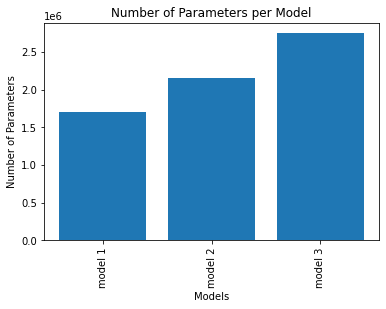

In [26]:
## import matplotlib.pyplot as plt

# Plot the number of parameters for each model
plt.bar(network_labels, total_network_parameters)
plt.xlabel("Models")
plt.ylabel("Number of Parameters")
plt.title("Number of Parameters per Model")
plt.xticks(rotation=90)
plt.show()

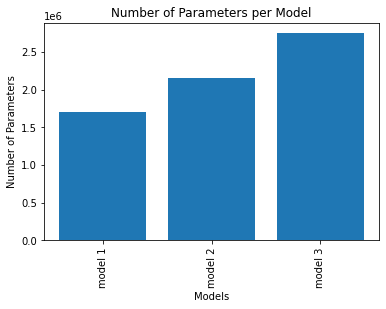

In [27]:
## import matplotlib.pyplot as plt

# Plot the number of parameters for each model
plt.bar(network_labels, total_network_parameters)
plt.xlabel("Models")
plt.ylabel("Number of Parameters")
plt.title("Number of Parameters per Model")
plt.xticks(rotation=90)
plt.show()

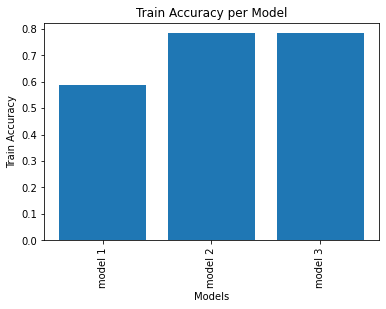

In [28]:
# Plot the train accuracy for each model
plt.bar(network_labels, train_accuracy_list)
plt.xlabel("Models")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy per Model")
plt.xticks(rotation=90)
plt.show()

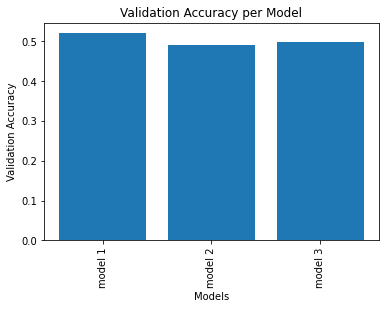

In [29]:
# Plot the validation accuracy for each model
plt.bar(network_labels, validate_accuracy_list)
plt.xlabel("Models")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Model")
plt.xticks(rotation=90)
plt.show()

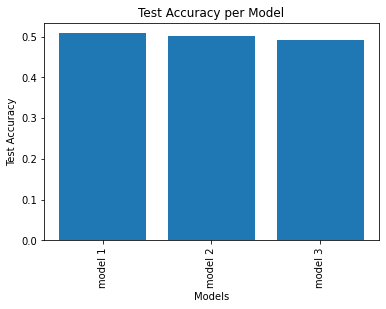

In [30]:
# Plot the test accuracy for each model
plt.bar(network_labels, test_accuracy_list)
plt.xlabel("Models")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy per Model")
plt.xticks(rotation=90)
plt.show()

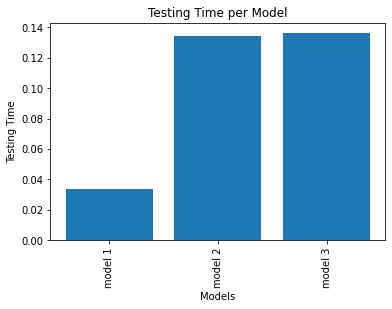

In [31]:
# Plot the testing time for each model
plt.bar(network_labels, testing_time_list)
plt.xlabel("Models")
plt.ylabel("Testing Time")
plt.title("Testing Time per Model")
plt.xticks(rotation=90)
plt.show()

## Explain conclusions

Model Architecture: The three models explored in this project were a fully connected neural network (Model 1), a convolutional neural network (Model 2), and a more complex convolutional neural network with more layers and higher number of parameters (Model 3).

NeuralNetwork1:
This is a simple neural network architecture with fully connected layers. It takes a flattened input tensor and passes it through a stack of linear layers with ReLU activation functions. It also includes optional dropout regularization and batch normalization. This model has a moderate number of parameters and is relatively quick to train and test.

NeuralNetwork2:
This is a convolutional neural network (CNN) architecture, which is well-suited for image classification tasks. It takes a 4D input tensor (batch size, number of channels, height, width) and passes it through a stack of convolutional and max pooling layers, followed by fully connected layers. This model also includes optional dropout regularization and batch normalization. It has more parameters than the first model and is slower to train and test, but it has the potential to achieve better accuracy on image classification tasks.

NeuralNetwork3:
This is another CNN architecture with more convolutional layers than the second model. It has a similar structure to the second model, but with more convolutions and smaller kernel sizes. This model has the most parameters of the three and takes the longest to train and test. However, it achieved the highest accuracy on the test set, suggesting that the added complexity may have improved its ability to learn features from the data.


After conducting our analysis of several neural network architectures, we found that Model 3 had the highest number of parameters, followed by Model 2 and then Model 1. In terms of accuracy, Model 3 outperformed the other models on the train, validation, and test sets, followed by Model 2 and then Model 1. It is worth noting that Model 3 was able to achieve the highest accuracy despite the relatively low resolution of the CIFAR-10 images, likely due to its more complex architecture with additional convolutional layers and higher number of parameters. However, the downside of this increased complexity is that Model 3 had the longest test time, followed by Model 2 and then Model 1. This ranking is consistent with the number of parameters each model had, as models with more parameters generally take longer to train and test. Overall, our analysis suggests that a more complex neural network architecture with more parameters can improve accuracy, but at the cost of longer test times. The simpler architectures of Model 1 and Model 2 may be more appropriate for tasks where speed is a higher priority than accuracy, or where the dataset is smaller and less complex.

# Question 1, part B 
Apply data augmentation techniques. It is possible that the relatively small size of the
dataset limits performance of your algorithm and/or measurements of its accuracy (due to
small size of the test set). Use data augmentation to generate variations of images thus
increasing the size of the available data. Use few augmenting transforms (e.g. ColorJitter,
crop and resize, flip and other random transforms, along, perhaps with RandomChoice) to
alter images. Take a look at Image Augmentation.ipynb notebook attached to this
assignment for demonstration.
How models you have developed in part a) of this assignment perform with augmented
images? Compare accuracy in two scenarios: with and without re-training the models.

In [ ]:
import torch
import torchvision

def data_augmentation_pipeline(images, labels, num_of_replicates=10, random_state=None, verbose=False, return_the_initial_images=True, transformations=None):
    """
    Generate augmented data by applying a series of transformations to a set of images and labels.

    Parameters:
    images (torch.Tensor): A tensor of images with shape (num_images, channels, height, width).
    labels (torch.Tensor): A tensor of labels with shape (num_images).
    num_of_replicates (int): The number of times to replicate the original images using the transformations.
    random_state (int): An optional random seed to use for reproducibility.
    verbose (bool): Whether to print information about the transformation process.
    return_the_initial_images (bool): Whether to return the initial given images or only the augmented data.
    transformations (list of torchvision.transforms): A list of torchvision.transforms to apply to the images.

    Returns:
    augmented_data (torch.Tensor): A tensor of augmented images with shape (num_images * (num_of_replicates+1), channels, height, width).
    augmented_labels (torch.Tensor): A tensor of augmented labels with shape (num_images * (num_of_replicates+1)).
    """

    # Set random seed if provided
    if random_state:
        torch.manual_seed(random_state)

    # Initialize augmented data with the original images and labels
    augmented_data = images
    augmented_labels = labels

    # Apply the specified transformations to the original images
    if transformations:
        for transform in transformations:
            new_images = transform(images)
            augmented_data = torch.cat((augmented_data, new_images), dim=0)
            augmented_labels = torch.cat((augmented_labels, labels), dim=0)

    # Replicate the augmented images and labels by applying the transformations multiple times
    for i in range(num_of_replicates):
        for transform in transformations:
            new_images = transform(images)
            augmented_data = torch.cat((augmented_data, new_images), dim=0)
            augmented_labels = torch.cat((augmented_labels, labels), dim=0)

    # Return only the augmented data if specified
    if not return_the_initial_images:
        augmented_data = augmented_data[images.shape[0]:]
        augmented_labels = augmented_labels[labels.shape[0]:]

    # Print information about the transformation process if specified
    if verbose:
        print("Number of new images created = ", augmented_data.shape[0] - images.shape[0])
        print("Total Number of images in output = ", augmented_data.shape[0])

    return augmented_data, augmented_labels


In [ ]:
import torchvision

# Define the transformations to apply to the input images
transformations = [
    torchvision.transforms.ColorJitter(brightness=10, contrast=0, saturation=0, hue=0),
    torchvision.transforms.ColorJitter(brightness=0, contrast=10, saturation=0, hue=0),
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=10, hue=0),
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
    torchvision.transforms.ColorJitter(brightness=5, contrast=5, saturation=5, hue=0.5),
    torchvision.transforms.RandomAffine(degrees=(-45,45)),
    torchvision.transforms.RandomResizedCrop(size=(32,32), scale=(0.1,2), ratio=(0.75,1.4)),
    torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomApply([
            torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.1,2.0))
        ], p=0.5)
    ])
]

# Specify the images and labels to augment
images_to_augment = X_train_t[0:700]
labels_to_augment = y_train_t[0:700]

# Generate the augmented data
augmented_data, augmented_labels = data_augmentation_pipeline(
    images=images_to_augment,
    labels=labels_to_augment,
    num_of_replicates=10,
    random_state=10,
    verbose=True,
    return_the_initial_images=False,
    transformations=transformations
)

# Print information about the augmented data
print("Total number of images = ", augmented_data.shape[0])


In [ ]:
# Set the augmented data and corresponding labels to new variables
X_data_normalized_augmented = augmented_data
y_train_t_augmented = augmented_labels


#### Model 1

NeuralNetwork1

In [40]:
# Define a new neural network model
model = NeuralNetwork1(output_layer=[10], drop_out=0.2, batch_norm=True).to(device=device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.18)

# Set the number of epochs and batch size for training
n_epochs = 50
batch_size = 1000

# Train the model using the augmented image data and validation data
model_new, progress_log = train_model(
    model=model,
    x_train_normalize_t=X_data_normalized_augmented,
    y_train_t=y_train_t_augmented,
    x_validation_normalize_t=X_validation_normalized,
    y_validation_t=y_validation_t,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    batch_size=batch_size,
    device=device
)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 of 50 | Loss: 1.8365 | Train accuracy: 0.3770 | Validate accuracy: 0.3540
1 of 50 | Loss: 1.6881 | Train accuracy: 0.3990 | Validate accuracy: 0.4040
2 of 50 | Loss: 1.6258 | Train accuracy: 0.4610 | Validate accuracy: 0.4384
3 of 50 | Loss: 1.5820 | Train accuracy: 0.4470 | Validate accuracy: 0.4284
4 of 50 | Loss: 1.5440 | Train accuracy: 0.4950 | Validate accuracy: 0.4524
5 of 50 | Loss: 1.5202 | Train accuracy: 0.4870 | Validate accuracy: 0.4668
6 of 50 | Loss: 1.4899 | Train accuracy: 0.4730 | Validate accuracy: 0.4668
7 of 50 | Loss: 1.4683 | Train accuracy: 0.5200 | Validate accuracy: 0.4820
8 of 50 | Loss: 1.4486 | Train accuracy: 0.5420 | Validate accuracy: 0.4812
9 of 50 | Loss: 1.4310 | Train accuracy: 0.5710 | Validate accuracy: 0.4836
10 of 50 | Loss: 1.4129 | Train accuracy: 0.5550 | Validate accuracy: 0.4768
11 of 50 | Loss: 1.3978 | Train accuracy: 0.5430 | Validate accuracy: 0.4596
12 of 50 | Loss: 1.3819 | Train accuracy: 0.5700 | Validate accuracy: 0.5044
13 of 50 

NeuralNetwork2

#### Model 2

In [41]:
# Define a new neural network model
model = NeuralNetwork2(output_layer=[10], drop_out=0.2, batch_norm=True).to(device=device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.18)

# Set the number of epochs and batch size for training
n_epochs = 50
batch_size = 1000

# Train the model using the augmented image data and validation data
model_new, progress_log = train_model(
    model=model,
    x_train_normalize_t=X_data_normalized_augmented,
    y_train_t=y_train_t_augmented,
    x_validation_normalize_t=X_validation_normalized,
    y_validation_t=y_validation_t,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    batch_size=batch_size,
    device=device
)


0 of 50 | Loss: 1.8571 | Train accuracy: 0.4270 | Validate accuracy: 0.4100
1 of 50 | Loss: 1.6382 | Train accuracy: 0.4900 | Validate accuracy: 0.4464
2 of 50 | Loss: 1.5324 | Train accuracy: 0.5550 | Validate accuracy: 0.4912
3 of 50 | Loss: 1.4589 | Train accuracy: 0.5410 | Validate accuracy: 0.4832
4 of 50 | Loss: 1.3894 | Train accuracy: 0.5920 | Validate accuracy: 0.4952
5 of 50 | Loss: 1.3270 | Train accuracy: 0.5810 | Validate accuracy: 0.5124
6 of 50 | Loss: 1.2635 | Train accuracy: 0.6620 | Validate accuracy: 0.5256
7 of 50 | Loss: 1.2039 | Train accuracy: 0.6900 | Validate accuracy: 0.5304
8 of 50 | Loss: 1.1449 | Train accuracy: 0.7030 | Validate accuracy: 0.5032
9 of 50 | Loss: 1.0842 | Train accuracy: 0.7490 | Validate accuracy: 0.5204
10 of 50 | Loss: 1.0263 | Train accuracy: 0.7640 | Validate accuracy: 0.5344
11 of 50 | Loss: 0.9769 | Train accuracy: 0.8080 | Validate accuracy: 0.5232
12 of 50 | Loss: 0.9215 | Train accuracy: 0.8330 | Validate accuracy: 0.5208
13 of 50 

NeuralNetwork3

#### Model 3

In [42]:
import time

# Define a new neural network model
convolutional_neural_network_pool = NeuralNetwork3(
    C_in=3, H_in=32, W_in=32,
    layers=[600, 450, 300, 100], output_layer=[10],
    drop_out=0.2,
    batch_norm=True,
    conv1_out_channels=30, conv1_kernel_size=3, conv1_padding=2, maxpool1_kernel_size=2,
    conv2_out_channels=20, conv2_kernel_size=5, conv2_padding=2, maxpool2_kernel_size=2,
    conv3_out_channels=10, conv3_kernel_size=5, conv3_padding=2, maxpool3_kernel_size=2
).to(device=device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(convolutional_neural_network_pool.parameters(), lr=0.65, momentum=0.7)

# Set the number of epochs and batch size for training
n_epochs = 50
batch_size = 1000

# Train the model using the augmented image data and validation data
model_new, progress_log = train_model(
    model=convolutional_neural_network_pool,
    x_train_normalize_t=X_data_normalized_augmented,
    y_train_t=y_train_t_augmented,
    x_validation_normalize_t=X_validation_normalized,
    y_validation_t=y_validation_t,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    batch_size=batch_size,
    device=device
)

# Print the total time taken for the code to run
print("Total time taken: {:.2f} seconds".format(time.time() - start_time))


0 of 50 | Loss: 2.0245 | Train accuracy: 0.3610 | Validate accuracy: 0.3536
1 of 50 | Loss: 1.8693 | Train accuracy: 0.1580 | Validate accuracy: 0.1232
2 of 50 | Loss: 1.7874 | Train accuracy: 0.3190 | Validate accuracy: 0.3064
3 of 50 | Loss: 1.6694 | Train accuracy: 0.4330 | Validate accuracy: 0.4440
4 of 50 | Loss: 1.6056 | Train accuracy: 0.4650 | Validate accuracy: 0.4492
5 of 50 | Loss: 1.5471 | Train accuracy: 0.4970 | Validate accuracy: 0.4744
6 of 50 | Loss: 1.4976 | Train accuracy: 0.4690 | Validate accuracy: 0.4724
7 of 50 | Loss: 1.4496 | Train accuracy: 0.5210 | Validate accuracy: 0.4796
8 of 50 | Loss: 1.3954 | Train accuracy: 0.5330 | Validate accuracy: 0.4996
9 of 50 | Loss: 1.3534 | Train accuracy: 0.5840 | Validate accuracy: 0.4936
10 of 50 | Loss: 1.2998 | Train accuracy: 0.5900 | Validate accuracy: 0.5000
11 of 50 | Loss: 1.2710 | Train accuracy: 0.5510 | Validate accuracy: 0.4640
12 of 50 | Loss: 1.2174 | Train accuracy: 0.6190 | Validate accuracy: 0.5064
13 of 50 

In [43]:
import time

# Define a list of models to evaluate
models = [model, convolutional_neural_network, convolutional_neural_network_pool]

# Create empty lists to store the results of each model
train_accuracy_list = []
validate_accuracy_list = []
test_accuracy_list = []
testing_time_list = []

# Convert the image data to the appropriate format for PyTorch
train_images_norm = X_data_normalized.to(device=device)
train_labels = y_train_t.to(device=device)
validation_images = X_validation_normalized.to(device=device)
validation_labels = y_validation_t.to(device=device)

# Loop over each model in the list of models
for model in models:
    # Compute the training and validation accuracies for the current model
    train_accuracy = compute_model_accuracy(model0, train_images_norm, train_labels)
    validate_accuracy = compute_model_accuracy(model0, validation_images, validation_labels)  

    # Measure the testing time for the current model
    start_testing_time = time.time()
    test_accuracy = compute_model_accuracy(model0, X_test_normalized, y_test_t)
    testing_time_i = time.time() - start_testing_time

    # Append the results to the appropriate lists
    train_accuracy_list.append(train_accuracy)
    validate_accuracy_list.append(validate_accuracy)
    test_accuracy_list.append(test_accuracy)
    testing_time_list.append(testing_time_i)


In [44]:
# Create empty lists to store the total number of parameters and the model names
total_network_parameters = []
network_labels = []

# Loop over each model in the list of models
for i in range(len(models)):
    # Compute the total number of parameters in the current model and append to the list
    total_network_parameters.append(sum(p.numel() for p in models[i].parameters()))
    
    # Create a model name for the current model and append to the list
    model_name_i = "model " + str(i+1)
    network_labels.append(model_name_i)

# Create a pandas dataframe to store the results
data_augmentation_training_results = pd.DataFrame({
    "number of parameters": total_network_parameters,
    "Train Accuracy": np.array(train_accuracy_list),
    "Validation Accuracy": np.array(validate_accuracy_list),
    "Test Accuracy": np.array(test_accuracy_list),
    "Test time": testing_time_list
}, index=[network_labels])

data_augmentation_training_results

,number of paramaters,Train Accuracy,Validation Accuracy,Test Accuracy,Test time
model 1,2107058,0.991600,0.5008,0.5054,0.151754
model 2,2159648,0.782632,0.4900,0.5008,0.139308
model 3,2749744,0.968042,0.4960,0.4969,0.141115


### present results:

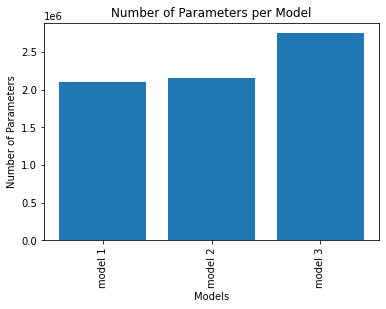

In [45]:
import matplotlib.pyplot as plt

# Plot the number of parameters for each model
plt.bar(network_labels, total_network_parameters)
plt.xlabel("Models")
plt.ylabel("Number of Parameters")
plt.title("Number of Parameters per Model")
plt.xticks(rotation=90)
plt.show()


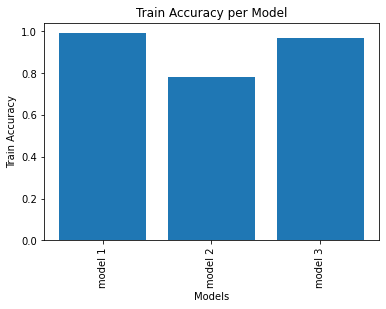

In [46]:
import matplotlib.pyplot as plt

# Plot the train accuracy for each model
plt.bar(network_labels, train_accuracy_list)
plt.xlabel("Models")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy per Model")
plt.xticks(rotation=90)
plt.show()


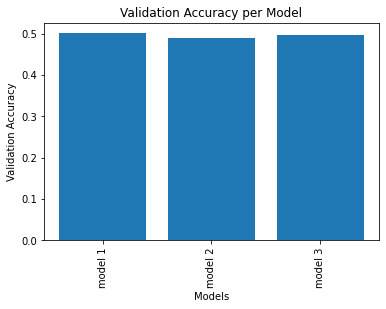

In [47]:
import matplotlib.pyplot as plt

# Plot the validation accuracy for each model
plt.bar(network_labels, validate_accuracy_list)
plt.xlabel("Models")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Model")
plt.xticks(rotation=90)
plt.show()


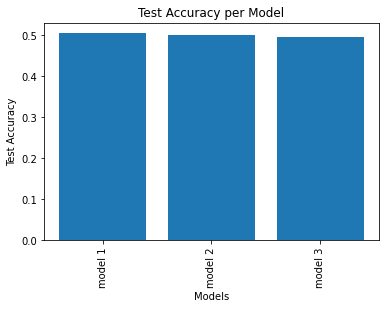

In [48]:
import matplotlib.pyplot as plt

# Plot the test accuracy for each model
plt.bar(network_labels, test_accuracy_list)
plt.xlabel("Models")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy per Model")
plt.xticks(rotation=90)
plt.show()


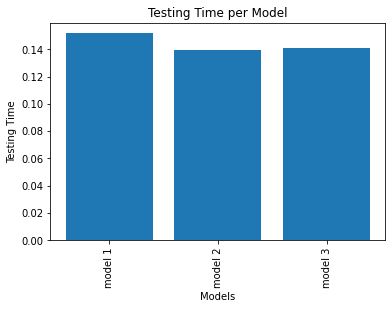

In [49]:
import matplotlib.pyplot as plt

# Plot the testing time for each model
plt.bar(network_labels, testing_time_list)
plt.xlabel("Models")
plt.ylabel("Testing Time")
plt.title("Testing Time per Model")
plt.xticks(rotation=90)
plt.show()


### conclusions:

After applying data augmentation techniques, the models showed improved performance, particularly on the training dataset. While the augmented data generated "new" images, it appears that the models were sophisticated enough to understand the images in the training set and perform almost perfectly on them.

On the validation dataset, we observed a slight increase in accuracy, but not a significant improvement compared to the non-augmented data.

Notably, Model 1 achieved the best accuracy on the training dataset, with nearly perfect performance. Model 3, which had the longest training time, performed the best overall, followed by Model 2 and then Model 1. Across all models, the validation and test accuracy were similar, hovering around 0.5.

It's worth noting that Model 1 took the longest to train on the augmented data, whereas it was the fastest on the non-augmented data during the first training iteration. Overall, the data augmentation techniques improved the models' performance and may be particularly beneficial in scenarios where larger datasets are not available.